# Multi-Class Single-Label classification

In [2]:
import os
os.environ["NUMEXPR_MAX_THREADS"] = "16"

import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import pandas as pd
import ltn

2024-04-27 22:38:11.392488: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-27 22:38:11.400352: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-27 22:38:11.474694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-27 22:38:13.073605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Define meta variables
test_fraction = 0.7
training_fraction = 1 - test_fraction
batch_size = 10000

Specify domain knowledge from the description of the IDS2017 dataset.

In [3]:

# list of all ips in the victim network in IDS 2017
own_win_servers = [
    "192.168.10.3",
]
own_linux_servers = [
    "192.168.10.50",
    "205.174.165.68",
    "192.168.10.51",
    "205.174.165.66",
]

own_ubuntu_pcs = [
    "192.168.10.19",
    "192.168.10.17",
    "192.168.10.16",
    "192.168.10.12",
]
own_windows_pcs = [
    "192.168.10.9",
    "192.168.10.5",
    "192.168.10.8",
    "192.168.10.14",
    "192.168.10.15",
]
own_mac_pcs = [
    "192.168.10.25",
]

own_server = own_win_servers + own_linux_servers
own_pcs = own_ubuntu_pcs + own_windows_pcs + own_mac_pcs
own_ips = own_server + own_pcs
webserver_ips = ["192.168.10.50", "192.168.10.51"]

# Data
| Type netflow  | Antall |
|---------------|--------|
|BENIGN         | 168 185|
|Brute Force    |   1 507|
|XSS            |     652|
|||
| **Totalt**    | **170 365**|

Train / test = 70% / 30%

### Individual example

| Attribute | example value |
|-----------|---------------|
|Protocol    | 6.0|
|Flow Duration  | 113095465.0|
|Total Length of Fwd Packets |  9668.0   |
|Total Length of Bwd Packets  |   10012.0|
|Fwd Header Length   |  1536.0|
|Bwd Header Length | 768.0
|Label | Benign|

In [3]:
with open("out.csv", "r") as file:
    dataset = pd.read_csv(file, delimiter=",")

print(dataset.head(3))

       Source IP   Source Port  Destination IP   Destination Port   Protocol  \
0  192.168.10.50         33898    192.168.10.3                389          6   
1  192.168.10.50         33904    192.168.10.3                389          6   
2        8.6.0.1             0         8.0.6.4                  0          0   

    Flow Duration  Total Length of Fwd Packets   Total Length of Bwd Packets  \
0       113095465                         9668                       10012.0   
1       113473706                        11364                       12718.0   
2       119945515                            0                           0.0   

    Fwd Header Length   Bwd Header Length  Fwd PSH Flags  FIN Flag Count  \
0                1536                 768              1               0   
1                2176                1280              1               0   
2                   0                   0              0               0   

    Bwd Packet Length Min  Init_Win_bytes_forward   I

## Partition the training set and test set

In [4]:
# Normalize all columns between 0 and 1
for column in dataset.columns:
    if column not in [" Label", " Source IP", " Destination IP"]:
        dataset[column] = (dataset[column] - dataset[column].min()) / (
            dataset[column].max() - dataset[column].min()
        )

In [5]:
dataset["is_webserver"] = dataset[" Destination IP"].apply(
    lambda x: 1 if x in webserver_ips else 0
)
dataset["from_own_network"] = dataset[" Source IP"].apply(
    lambda x: 1 if x in own_ips else 0
)
dataset["to_own_network"] = dataset[" Destination IP"].apply(
    lambda x: 1 if x in own_ips else 0
)
## remove the columns " Source IP" and " Destination IP"
dataset = dataset.drop(columns=[" Source IP", " Destination IP"])



In [6]:
print(dataset.head(3))

    Source Port   Destination Port   Protocol   Flow Duration  \
0      0.517258           0.005936   0.352941        0.942462   
1      0.517350           0.005936   0.352941        0.945614   
2      0.000000           0.000000   0.000000        0.999546   

   Total Length of Fwd Packets   Total Length of Bwd Packets  \
0                     0.008076                      0.000016   
1                     0.009492                      0.000020   
2                     0.000000                      0.000000   

    Fwd Header Length   Bwd Header Length  Fwd PSH Flags  FIN Flag Count  \
0            0.000368            0.000142            1.0             0.0   
1            0.000521            0.000236            1.0             0.0   
2            0.000000            0.000000            0.0             0.0   

    Bwd Packet Length Min  Init_Win_bytes_forward   Init_Win_bytes_backward  \
0                0.216438                0.008728                  0.031738   
1                0.

In [7]:
done = False
nr_tries = 1

while (not done):
    print("Try number: ", nr_tries)
    nr_tries += 1
    # partition the dataset into 4 classes
    benign = dataset[dataset[" Label"] == "BENIGN"]
    brute_force = dataset[dataset[" Label"] == "Web Attack � Brute Force"]
    xss = dataset[dataset[" Label"] == "Web Attack � XSS"]

    # keep 50000 random samples of the benign class
    # benign_cpy = benign.copy()
    # benign = benign.sample(n=1300)
    # benign_cpy = benign_cpy.drop(benign.index)

    # 70% of each class for training and the remainding 30% for testing
    benign_train = benign.sample(frac=test_fraction)
    benign_test = benign.drop(benign_train.index)
    brute_force_train = brute_force.sample(frac=test_fraction)
    brute_force_test = brute_force.drop(brute_force_train.index)
    xss_train = xss.sample(frac=test_fraction)
    xss_test = xss.drop(xss_train.index)

    # randomly conatenate all the dataframes
    training_set = pd.concat([benign_train, brute_force_train, xss_train])
    test_set = pd.concat([benign_test, brute_force_test, xss_test])

    # # create final test set
    # final_test_set = pd.concat([benign_cpy, brute_force_test, xss_test])
    # final_test_labels = final_test_set.pop(" Label")
    # final_test_labels = final_test_labels.replace("BENIGN", 0).replace("Web Attack � Brute Force", 1).replace("Web Attack � XSS", 2)
    # final_test_metadata = final_test_set[["is_webserver", "from_own_network", "to_own_network"]]
    # final_test_set = final_test_set.drop(columns=["is_webserver", "from_own_network", "to_own_network"])

    # shuffle the dataframes
    training_set = training_set.sample(frac=1).reset_index(drop=True)
    test_set = test_set.sample(frac=1).reset_index(drop=True)

    labels_train = training_set.pop(" Label")
    labels_test = test_set.pop(" Label")
    ## create a metadata tensor with the columns "is_webserver", "from_own_network", "to_own_network"
    metadata_train = training_set[["is_webserver", "from_own_network", "to_own_network"]]
    metadata_test = test_set[["is_webserver", "from_own_network", "to_own_network"]]
    # remove the columns "is_webserver", "from_own_network", "to_own_network" from the training and test set
    training_set = training_set.drop(columns=["is_webserver", "from_own_network", "to_own_network"])
    test_set = test_set.drop(columns=["is_webserver", "from_own_network", "to_own_network"])

    # convert the labels to a numeric value
    labels_train = labels_train.replace("BENIGN", 0)
    labels_train = labels_train.replace("Web Attack � Brute Force", 1)
    labels_train = labels_train.replace("Web Attack � XSS", 2)

    labels_test = labels_test.replace("BENIGN", 0)
    labels_test = labels_test.replace("Web Attack � Brute Force", 1)
    labels_test = labels_test.replace("Web Attack � XSS", 2)

    ds_train = tf.data.Dataset.from_tensor_slices(
        (training_set, labels_train, metadata_train)
    ).batch(batch_size)
    ds_test = tf.data.Dataset.from_tensor_slices(
        (test_set, labels_test, metadata_test)
    ).batch(batch_size)

    ## ~~test part~~
    done = True

    batches_train = len(training_set) // batch_size
    batches_test = len(test_set) // batch_size
    for i in range(batches_train):
        benign_count = 0
        brute_force_count = 0
        xss_count = 0
        for j in range(i * batch_size, (i + 1) * batch_size):
            # count the number of benign, brute force and xss attacks in the training set

            if labels_train[j] == 0:
                benign_count += 1
            elif labels_train[j] == 1:
                brute_force_count += 1
            else:
                xss_count += 1
        if benign_count == 0 or brute_force_count == 0 or xss_count == 0:
            done = False
    for i in range(batches_test):
        benign_count = 0
        brute_force_count = 0
        xss_count = 0
        for j in range(i * batch_size, (i + 1) * batch_size):
            # count the number of benign, brute force and xss attacks in the test set
            if labels_test[j] == 0:
                benign_count += 1
            elif labels_test[j] == 1:
                brute_force_count += 1
            else:
                xss_count += 1
        if benign_count == 0 or brute_force_count == 0 or xss_count == 0:
            done = False

Try number:  1


2024-03-11 10:59:25.493468: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
print(training_set.head(3))

    Source Port   Destination Port   Protocol   Flow Duration  \
0      0.235923           0.000809   1.000000        0.000001   
1      0.962966           0.000809   1.000000        0.000260   
2      0.539262           0.006760   0.352941        0.968802   

   Total Length of Fwd Packets   Total Length of Bwd Packets  \
0                     0.000053                  1.913876e-07   
1                     0.000127                  3.221691e-07   
2                     0.000979                  6.430622e-06   

    Fwd Header Length   Bwd Header Length  Fwd PSH Flags  FIN Flag Count  \
0            0.000015            0.000012            0.0             0.0   
1            0.000025            0.000012            0.0             0.0   
2            0.000115            0.000071            0.0             0.0   

    Bwd Packet Length Min  Init_Win_bytes_forward   Init_Win_bytes_backward  \
0                0.041096                0.000000                  0.000000   
1                0.

In [9]:
batches_train = len(training_set) // batch_size
batches_test = len(test_set) // batch_size
print("~~~Train~~~")
for i in range(batches_train):
    benign_count = 0
    brute_force_count = 0
    xss_count = 0
    for j in range(i*batch_size, (i+1)*batch_size):
        # count the number of benign, brute force and xss attacks in the training set
        
        if labels_train[j] == 0:
            benign_count += 1
        elif labels_train[j] == 1:
            brute_force_count += 1
        else:
            xss_count += 1
    print(f"from {i*batch_size} to {(i+1)*batch_size}: benign: {benign_count}, brute force: {brute_force_count}, xss: {xss_count}")

print("\n~~~Test~~~")
for i in range(batches_test):
    benign_count = 0
    brute_force_count = 0
    xss_count = 0
    for j in range(i*batch_size, (i+1)*batch_size):
        # count the number of benign, brute force and xss attacks in the test set
        if labels_test[j] == 0:
            benign_count += 1
        elif labels_test[j] == 1:
            brute_force_count += 1
        else:
            xss_count += 1
    print(f"from {i*batch_size} to {(i+1)*batch_size}: benign: {benign_count}, brute force: {brute_force_count}, xss: {xss_count}")


~~~Train~~~
from 0 to 10000: benign: 9878, brute force: 80, xss: 42
from 10000 to 20000: benign: 9881, brute force: 84, xss: 35
from 20000 to 30000: benign: 9881, brute force: 88, xss: 31
from 30000 to 40000: benign: 9867, brute force: 90, xss: 43
from 40000 to 50000: benign: 9872, brute force: 97, xss: 31
from 50000 to 60000: benign: 9865, brute force: 95, xss: 40
from 60000 to 70000: benign: 9866, brute force: 99, xss: 35
from 70000 to 80000: benign: 9873, brute force: 81, xss: 46
from 80000 to 90000: benign: 9849, brute force: 97, xss: 54
from 90000 to 100000: benign: 9876, brute force: 86, xss: 38
from 100000 to 110000: benign: 9898, brute force: 74, xss: 28

~~~Test~~~
from 0 to 10000: benign: 9880, brute force: 85, xss: 35
from 10000 to 20000: benign: 9868, brute force: 99, xss: 33
from 20000 to 30000: benign: 9876, brute force: 84, xss: 40
from 30000 to 40000: benign: 9860, brute force: 95, xss: 45
from 40000 to 50000: benign: 9878, brute force: 83, xss: 39


# LTN
Predicate for klassetilhørighet `P(x,class)`

En fully connected MLP (16,16,8)

In [38]:
class MLP(tf.keras.Model):
    """Model that returns logits."""

    def __init__(self, n_classes, hidden_layer_sizes=(16, 16, 8)):
        super(MLP, self).__init__()
        self.denses = [
            tf.keras.layers.Dense(s, activation="elu") for s in hidden_layer_sizes
        ]
        self.dense_class = tf.keras.layers.Dense(n_classes)
        self.dropout = tf.keras.layers.Dropout(0.2)

    def call(self, inputs, training=False):
        x = inputs[0]
        for dense in self.denses:
            x = dense(x)
            x = self.dropout(x, training=training)
        return self.dense_class(x)


logits_model = MLP(3)
p = ltn.Predicate.FromLogits(
    logits_model, activation_function="softmax", with_class_indexing=True
)

Definere klassene `Benign, brute force, xss`

In [39]:
class_benign = ltn.Constant(0, trainable=False)
class_brute_force = ltn.Constant(1, trainable=False)
class_xss = ltn.Constant(2, trainable=False)

def get_class_name(class_index):
    if class_index == 0:
        return "BENIGN"
    elif class_index == 1:
        return "Brute Force"
    else:
        return "XSS"

In [40]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")

# Definerer Real logic statements 

<p align="center"> <i> Ground with labeled data </i> </p>

$$ \forall x\_l\_benign P(x\_l\_benign, Class\_Benign) $$
$$ \forall x\_l\_bruteForce P(x\_l\_bruteForce, Class\_BruteForce) $$
$$ \forall x\_l\_xss P(x\_l\_xss, Class\_XSS) $$

---

<p align="center"> <i>Any non-websever cannot be classified as having a web-attack</i> </p>

$$ \forall x\_not\_webserver \neg (P(x\_not\_webserver, Class\_bruteForce) \wedge P(x\_not\_webserver, Class\_XSS)) $$

---

<p align="center"> <i>Taffic between two nodes the server owns cannot be a webattack</i> </p>

$$ \forall x\_internal\_communication \neg (P(x\_internal\_communication, Class\_bruteForce) \wedge P(x\_internal\_communication, Class\_XSS)) $$



In [41]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(
    ltn.fuzzy_ops.Aggreg_pMeanError(p=2)
)


@tf.function
def axioms(features, labels, metadata, training=False):     
    x_Benign = ltn.Variable("x_Benign", features[labels == 0])
    x_Brute_Force = ltn.Variable("x_Brute_Force", features[labels == 1])
    x_XSS = ltn.Variable("x_XSS", features[labels == 2])


    # # traffic from webserver
    # ws_index = list(metadata_train.columns).index("is_webserver")
    # x_not_webserver = ltn.Variable(
    #     "x_not_webserver", features[metadata[:, ws_index] == 0]
    # )

    # traffic where from_own_network = 1 and to_own_network = 1
    from_index = list(metadata_train.columns).index("from_own_network")
    to_index = list(metadata_train.columns).index("to_own_network")
    x_internal_traffic = ltn.Variable(
        "x_internal_traffic",
        features[(metadata[:, from_index] == 1) & (metadata[:, to_index] == 1)],
    )

    axioms = [
        Forall(x_Benign, p([x_Benign, class_benign], training=training)),
        Forall(x_Brute_Force, p([x_Brute_Force, class_brute_force], training=training)),
        Forall(x_XSS, p([x_XSS, class_xss], training=training)),
        # only webserver traffic is brute force or xss
        # Forall(
        #     x_not_webserver,
        #     Not(
        #         Or(
        #             p([x_not_webserver, class_brute_force], training=training),
        #             p([x_not_webserver, class_xss], training=training),
        #         )
        #     ),
        # ),
        # Internal traffic is not brute force or xss
        Forall(
            x_internal_traffic,
            Not(
                Or(
                    p([x_internal_traffic, class_brute_force], training=training),
                    p([x_internal_traffic, class_xss], training=training),
                )
            ),
        )
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

Initialize all layers and the static graph

In [42]:
for features, labels, metadata in ds_test:
    print("Initial sat level %.5f"%axioms(features,labels, metadata))
    break


Initial sat level 0.33972


# Training

In [43]:
metrics_dict = {
    'train_sat_kb': tf.keras.metrics.Mean(name='train_sat_kb'),
    'test_sat_kb': tf.keras.metrics.Mean(name='test_sat_kb'),
    'train_accuracy': tf.keras.metrics.CategoricalAccuracy(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.CategoricalAccuracy(name="test_accuracy")
}

### Outline
1. Finn aggregert sannhet
   1. Loss = 1 - aggregert sannhet
2. Adam Optimizer for gradient descent 

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
@tf.function
def train_step(features, labels, metadata):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(features, labels, metadata, training=True)
        loss = 1.-sat
    gradients = tape.gradient(loss, p.trainable_variables)
    optimizer.apply_gradients(zip(gradients, p.trainable_variables))

    sat = axioms(features, labels, metadata) # compute sat without dropout
    metrics_dict['train_sat_kb'](sat)
    # accuracy
    predictions = logits_model([features])
    metrics_dict['train_accuracy'](tf.one_hot(labels,3),predictions)
    
@tf.function
def test_step(features, labels, metadata):
    # sat
    sat = axioms(features, labels, metadata)
    metrics_dict['test_sat_kb'](sat)
    # accuracy
    predictions = logits_model([features])
    metrics_dict['test_accuracy'](tf.one_hot(labels,3),predictions)

Train

In [90]:
import importlib
import commons
importlib.reload(commons)
EPOCHS = 200 # 400 
 
commons.train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path="iris_results.csv",
    track_metrics=20
)

Epoch 0, train_sat_kb: 0.6821, test_sat_kb: 0.6670, train_accuracy: 0.9323, test_accuracy: 0.9360
Epoch 20, train_sat_kb: 0.6831, test_sat_kb: 0.6685, train_accuracy: 0.9309, test_accuracy: 0.9353
Epoch 40, train_sat_kb: 0.6854, test_sat_kb: 0.6701, train_accuracy: 0.9337, test_accuracy: 0.9302
Epoch 60, train_sat_kb: 0.6863, test_sat_kb: 0.6716, train_accuracy: 0.9355, test_accuracy: 0.9339
Epoch 80, train_sat_kb: 0.6868, test_sat_kb: 0.6722, train_accuracy: 0.9296, test_accuracy: 0.9283
Epoch 100, train_sat_kb: 0.6867, test_sat_kb: 0.6721, train_accuracy: 0.9282, test_accuracy: 0.9341
Epoch 120, train_sat_kb: 0.6891, test_sat_kb: 0.6751, train_accuracy: 0.9316, test_accuracy: 0.9317
Epoch 140, train_sat_kb: 0.6886, test_sat_kb: 0.6744, train_accuracy: 0.9337, test_accuracy: 0.9365
Epoch 160, train_sat_kb: 0.6907, test_sat_kb: 0.6755, train_accuracy: 0.9359, test_accuracy: 0.9379
Epoch 180, train_sat_kb: 0.6903, test_sat_kb: 0.6741, train_accuracy: 0.9391, test_accuracy: 0.9420


In [91]:
import math

predictions = logits_model([tf.convert_to_tensor(test_set)])
confusion_matrix = tf.math.confusion_matrix(
    labels_test, tf.argmax(predictions, axis=1), num_classes=3
)

print("Confusion Matrix")
print(confusion_matrix)


print("|    Label    |  TP    |   FP  |   FN  | Precision | Recall |   F1  |  MCC  |")
print("|-------------|--------|-------|-------|-----------|--------|-------|-------|")

# for each class, compute the precision, recall and f1 score
for i in range(3):
    tp = int((confusion_matrix[i, i]))
    fn = int(tf.reduce_sum(confusion_matrix[i, :]) - confusion_matrix[i, i])
    fp = int(tf.reduce_sum(confusion_matrix[:, i]) - confusion_matrix[i, i])
    tn = int(tf.reduce_sum(confusion_matrix) - tp - fp - fn)


    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = (2 * precision * recall) / (precision + recall)
    mcc = (tp * tn - fp * fn) / math.sqrt(((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    print(
        f"| {get_class_name(i):11} | {tp:6} | {fp:5} | {fn:5} | {precision:9.3f} | {recall:6.3f} | {f1:5.3f} | {mcc:3.3f} |"
    )

Confusion Matrix
tf.Tensor(
[[47333  1872  1251]
 [    1   311   140]
 [    1    19   176]], shape=(3, 3), dtype=int32)
|    Label    |  TP    |   FP  |   FN  | Precision | Recall |   F1  |  MCC  |
|-------------|--------|-------|-------|-----------|--------|-------|-------|
| BENIGN      |  47333 |     2 |  3123 |     1.000 |  0.938 | 0.968 | 0.400 |
| Brute Force |    311 |  1891 |   141 |     0.141 |  0.688 | 0.234 | 0.300 |
| XSS         |    176 |  1391 |    20 |     0.112 |  0.898 | 0.200 | 0.312 |


# Take 4
``Individuals``: 51104
`batch size`: 10000
`epocs`: 200

> no knowledge

|    Label    |  TP    |   FP  |   FN  | Precision | Recall |   F1  | Check | 
|-------------|--------|-------|-------|-----------|--------|-------|-------|
| BENIGN      |  46227 |    28 |  4229 |     0.999 |  0.916 | 0.956 |       |
| Brute Force |    310 |  3143 |   142 |     0.090 |  0.686 | 0.159 | 452   |
| XSS         |    123 |  1273 |    73 |     0.088 |  0.628 | 0.155 |       |
| Sammen      |   4660 |  4444 |  4444 |     0.392 |  0.743 | 0.423 |       |

> webattacks on web servers

|    Label    |  TP    |   FP  |   FN  | Precision | Recall |   F1  | Check |
|-------------|--------|-------|-------|-----------|--------|-------|-------|
| BENIGN      |  48612 |    82 |  1844 |     0.998 |  0.963 | 0.981 |       |
| Brute Force |    281 |  1533 |   171 |     0.155 |  0.622 | 0.248 | 452   |
| XSS         |    127 |   469 |    69 |     0.213 |  0.648 | 0.321 |       |
| Sammen      |  49020 |  2084 |  2084 |     0.455 |  0.744 | 0.517 |       |

> no inside attacks

|    Label    |  TP    |   FP  |   FN  | Precision | Recall |   F1  |  MCC  |
|-------------|--------|-------|-------|-----------|--------|-------|-------|
| BENIGN      |  47455 |    47 |  3001 |     0.999 |  0.941 | 0.969 | 0.379 |
| Brute Force |    318 |  1853 |   134 |     0.146 |  0.704 | 0.242 | 0.310 |
| XSS         |    122 |  1309 |    74 |     0.085 |  0.622 | 0.150 | 0.224 |
| Sammen      |  47895 |  3209 |  3209 |     0.410 |  0.756 | 0.454 | 0.301 |

> all knowledge

|    Label    |  TP    |   FP  |   FN  | Precision | Recall |   F1  | Check |
|-------------|--------|-------|-------|-----------|--------|-------|-------|
| BENIGN      |  48680 |    82 |  1776 |     0.998 |  0.965 | 0.981 |       |
| Brute Force |    271 |  1057 |   181 |     0.204 |  0.600 | 0.304 | 452   |
| XSS         |    123 |   891 |    73 |     0.121 |  0.628 | 0.203 |       |
| Sammen      |  49074 |  2030 |  2030 |     0,441 |  0,731 | 0.496 |       |


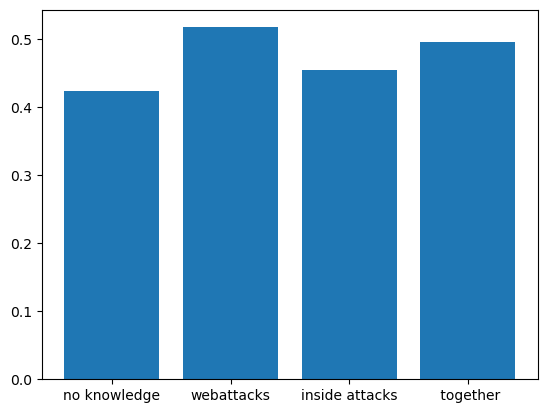

In [92]:
import matplotlib.pyplot as plt

labels = ["no knowledge", "webattacks", "inside attacks", " together"]
values = [0.423, 0.517, 0.454, 0.496]
plt.bar(labels, values)
plt.show()

# Take 3
`individuals` = 15648
`batch size` = 1000 
`epochs` = 100

> no knowledge

|    Label    | TP    |   FN  |   FP  | Recall    | Precision |   F1  |
|-------------|-------|-------|-------|-----------|--------|-------|
| BENIGN      | 13370 |  1630 |    12 |     0.891 |  0.999 | 0.942 |
| Brute Force |   189 |   263 |  1330 |     0.418 |  0.124 | 0.192 |
| XSS         |   130 |    66 |   617 |     0.663 |  0.174 | 0.276 |

> web attack knowledge

|    Label    | TP    |   FN  |   FP  | Recall    | Precision |   F1  |
|-------------|-------|-------|-------|-----------|--------|-------|
| BENIGN      | 14170 |   830 |    31 |     0.945 |  0.998 | 0.971 |
| Brute Force |   330 |   122 |   580 |     0.730 |  0.363 | 0.485 |
| XSS         |   129 |    67 |   408 |     0.658 |  0.240 | 0.352 |


> inside attack knowledge

|    Label    | TP    |   FN  |   FP  | Recall    | Precision |   F1  |
|-------------|-------|-------|-------|-----------|--------|-------|
| BENIGN      | 13885 |  1115 |    24 |     0.926 |  0.998 | 0.961 |
| Brute Force |   237 |   215 |   829 |     0.524 |  0.222 | 0.312 |
| XSS         |   130 |    66 |   543 |     0.663 |  0.193 | 0.299 |

> web attack & inside attack knowledge

|    Label    | TP    |   FN  |   FP  | Recall    | Precision |   F1  |
|-------------|-------|-------|-------|-----------|--------|-------|
| BENIGN      | 14297 |   703 |    68 |     0.953 |  0.995 | 0.974 |
| Brute Force |   281 |   171 |   309 |     0.622 |  0.476 | 0.539 |
| XSS         |   130 |    66 |   563 |     0.663 |  0.188 | 0.292 |



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

no_knowledge = [0.942, 0.192, 0.276]
web_attack = [0.971, 0.485, 0.352]
no_inside = [0.961, 0.312, 0.299]
both = [0.971, 0.539, 0.292]

labels = ["Benign F1", "Brute Force F1", "XSS F1"]
x = np.arange(len(labels))
width = 0.20
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, no_knowledge, width, label="No Knowledge")
rects2 = ax.bar(x, web_attack, width, label="Web Attack")
rects3 = ax.bar(x + width, no_inside, width, label="No Inside")
rects4 = ax.bar(x + 2 * width, both, width, label="Both")


ax.set_ylabel("F1 Score")
ax.set_title("F1 Score by Label")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# save

`ephocs` = 1440

|    Label    | TP    |   FP  |   FN  | Precision | Recall |   F1  |
|-------------|-------|-------|-------|-----------|--------|-------|
| BENIGN      | 14287 |   713 |     9 |     0.952 |  0.999 | 0.975 |
| Brute Force |   309 |   143 |   559 |     0.684 |  0.356 | 0.468 |
| XSS         |   180 |    16 |   304 |     0.918 |  0.372 | 0.529 |

masse trening: 
|    Label    | TP    |   FP  |   FN  | Precision | Recall |   F1  |
|-------------|-------|-------|-------|-----------|--------|-------|
| BENIGN      |   699 |    51 |     0 |     0.932 |  1.000 | 0.965 |
| Brute Force |   315 |   137 |    37 |     0.697 |  0.895 | 0.784 |
| XSS         |   190 |     6 |   157 |     0.969 |  0.548 | 0.700 |

# Take 2
`Epochs = 100`

> No knowledge

| Label | TP | FP | TN | FN | Precision | Recall | F1 |
|-------|----|----|----|----|-----------|--------|----|
| Benign | 44207 | 375 | 212 | 6310 | 0.991588533488852 | 0.8750915533384801 | 0.9297048339099254 |
| Brute Force | 212 | 5242 | 45625 | 25 | 0.0388705537220 | 0.894514767932 | 0.0745036021788 |
| XSS | 129 | 1068 | 49661 | 246 | 0.10776942355889724 | 0.344 | 0.16412213740458015 |

> Also only webattacks on web servers

| Label | TP | FP | TN | FN | Precision | Recall | F1 |
|-------|----|----|----|----|-----------|--------|----|
| Benign | 50448 | 303 | 279 | 74 | 0.9940296742921322 | 0.9985352915561537 | 0.9962773888400659 |
| Brute Force | 279 | 74 | 50751 | 0 | 0.7903682719546742 | 1.0 | 0.8829113924050632 |
| XSS | 130 | 0 | 50801 | 173 | 1.0 | 0.429042904290429 | 0.6004618937644342 |
> Also no inside -> inside attacks

| Label | TP | FP | TN | FN | Precision | Recall | F1 |
|-------|----|----|----|----|-----------|--------|----|
| Benign | 50452 | 331 | 253 | 68 | 0.9934820707717149 | 0.9986539984164687 | 0.9960613209875324 |
| Brute Force | 253 | 68 | 50783 | 0 | 0.7881619937694704 | 1.0 | 0.8815331010452961 |
| XSS | 132 | 0 | 50773 | 199 | 1.0 | 0.3987915407854985 | 0.5701943844492441 |


> Together 

|    type         | Benign F1 | Brute Force F1 | XSS F1 |
|-----------------|-----------|----------------|--------|
| No Knowledge    | 0.930     | 0.074          | 0.164  |
| with Web attack | 0.996     | 0.833          | 0.600  |
| no Inside attack| 0.996     | 0.882          | 0.570  |
